# Environment Setup in GCP
- apt-get --purge remove "cublas" "cuda*"
- reboot
- sudo curl -O http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
- sudo dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb sudo apt-key adv --fetch-keys http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
- sudo apt-get install cuda-10-1
- pip3 install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
- pip3 install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
- pip3 install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
- pip3 install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
- pip3 install torch-geometric

** Both the PyTorch and torch_sparse CUDA version must matched

In [1]:
!python3 -c "import torch; print(torch.version.cuda)"

10.1


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import sklearn.metrics as metrics

import time
from datetime import datetime

import networkx as nx
import numpy as np

import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [5]:
print(len(trainset))
print(trainset[10])

60000
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)
        #x = x.view(32, -1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [7]:
import numpy as np
a = np.array([[1,2],[3,4]])
b = np.ones((2,2))

ta = torch.tensor(a, dtype=float).to('cuda:0')
tb = torch.ones(2,2, dtype=float).to('cuda:0')

print(ta)
print(tb)
print(ta @ tb) # dot product; element-wise product

# This takes awhile for CUDA configurations

tensor([[1., 2.],
        [3., 4.]], device='cuda:0', dtype=torch.float64)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', dtype=torch.float64)
tensor([[3., 3.],
        [7., 7.]], device='cuda:0', dtype=torch.float64)


In [8]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device : ", device)

model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Current device :  cuda:0


In [9]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item()
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6178 | Train Accuracy: 0.85
Epoch: 1 | Loss: 1.4964 | Train Accuracy: 0.97
Epoch: 2 | Loss: 1.4852 | Train Accuracy: 0.98
Epoch: 3 | Loss: 1.4800 | Train Accuracy: 0.98
Epoch: 4 | Loss: 1.4764 | Train Accuracy: 0.99


In [10]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs, 1).flatten().cpu().numpy()
        
print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 0.98


In [11]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [12]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Removes every self-loop in the graph given by edge_index
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)

        # Transform node feature matrix.
        self_x = self.lin_self(x)
        #x = self.lin(x)

        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_i, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

In [13]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

In [14]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

In [15]:
#pip3 install tensorboardX
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

In [16]:
#get_ipython().system_raw(
#    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#    .format("./log")
#)


In [17]:
#get_ipython().system_raw('./ngrok http 6006 &')
#!curl -s http://localhost:4040/api/tunnels | python3 -c \
#    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [18]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!
Epoch 0. Loss: 1.8315. Test accuracy: 0.1333
Epoch 10. Loss: 1.7663. Test accuracy: 0.2083
Epoch 20. Loss: 1.7629. Test accuracy: 0.2000
Epoch 30. Loss: 1.7574. Test accuracy: 0.2167
Epoch 40. Loss: 1.7643. Test accuracy: 0.1917
Epoch 50. Loss: 1.7626. Test accuracy: 0.2167
Epoch 60. Loss: 1.7502. Test accuracy: 0.2167
Epoch 70. Loss: 1.7517. Test accuracy: 0.2417
Epoch 80. Loss: 1.7527. Test accuracy: 0.2167
Epoch 90. Loss: 1.7532. Test accuracy: 0.2333
Epoch 100. Loss: 1.7472. Test accuracy: 0.2000
Epoch 110. Loss: 1.7526. Test accuracy: 0.2083
Epoch 120. Loss: 1.7421. Test accuracy: 0.2333
Epoch 130. Loss: 1.7629. Test accuracy: 0.2417
Epoch 140. Loss: 1.7541. Test accuracy: 0.2250
Epoch 150. Loss: 1.7518. Test accuracy: 0.1833
Epoch 160. Loss: 1.7432. Test accuracy: 0.2500
Epoch 170. Loss: 1.7478. Test accuracy: 0.2167
Epoch 180. Loss: 1.7540. Test accuracy: 0.2417
Epoch 190. Loss: 1.7489. Test accuracy: 0.2583


In [19]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

model = train(dataset, task, writer)

Epoch 0. Loss: 1.9435. Test accuracy: 0.3290
Epoch 10. Loss: 0.3900. Test accuracy: 0.7680
Epoch 20. Loss: 0.1119. Test accuracy: 0.7700
Epoch 30. Loss: 0.0057. Test accuracy: 0.7300
Epoch 40. Loss: 0.0242. Test accuracy: 0.7430
Epoch 50. Loss: 0.0076. Test accuracy: 0.7460
Epoch 60. Loss: 0.0050. Test accuracy: 0.7440
Epoch 70. Loss: 0.0055. Test accuracy: 0.7420
Epoch 80. Loss: 0.0047. Test accuracy: 0.7110
Epoch 90. Loss: 0.0252. Test accuracy: 0.7200
Epoch 100. Loss: 0.0295. Test accuracy: 0.7540
Epoch 110. Loss: 0.0034. Test accuracy: 0.7340
Epoch 120. Loss: 0.1122. Test accuracy: 0.7300
Epoch 130. Loss: 0.0034. Test accuracy: 0.7540
Epoch 140. Loss: 0.0165. Test accuracy: 0.7520
Epoch 150. Loss: 0.0054. Test accuracy: 0.7620
Epoch 160. Loss: 0.0197. Test accuracy: 0.7690
Epoch 170. Loss: 0.0023. Test accuracy: 0.7390
Epoch 180. Loss: 0.0327. Test accuracy: 0.7400
Epoch 190. Loss: 0.0138. Test accuracy: 0.7360


# Visualizing node embeddings

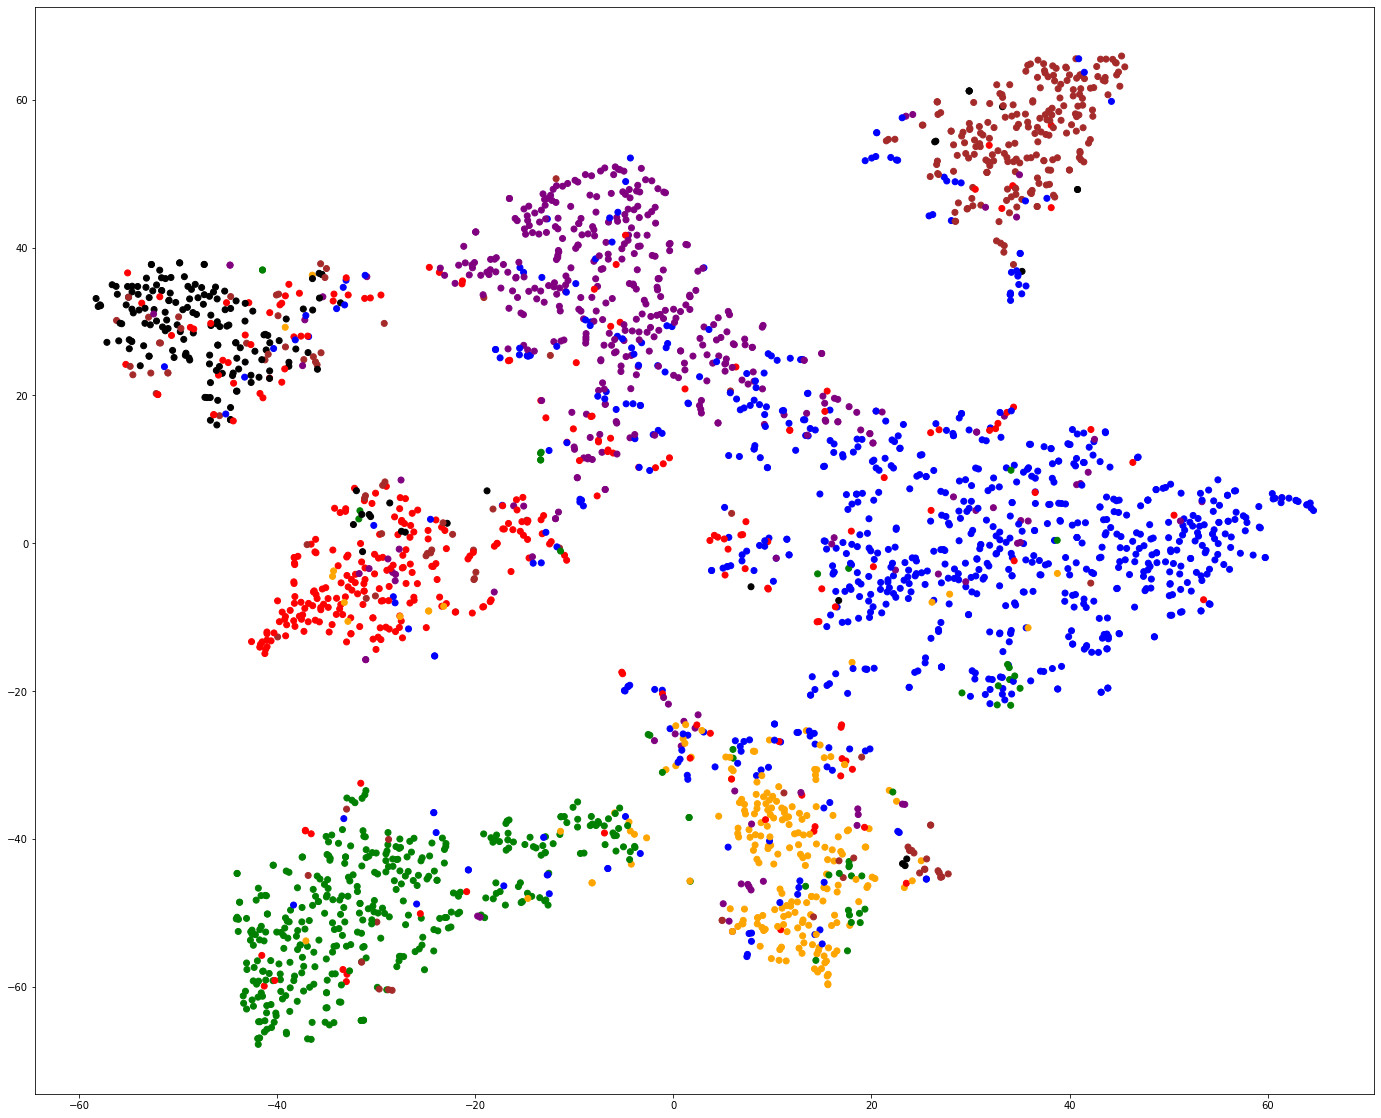

In [20]:
color_list = ["red", "orange", "green", "blue", "purple", "brown",
              "black", "yellow", "grey", "cyan", "pink", "magenta"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))

plt.figure(figsize=(24, 20))
plt.scatter(xs, ys, color=colors)
plt.show()

In [21]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    
    writer.add_scalar("loss", loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid("/tmp/citeseer", "Citeseer", T.NormalizeFeatures())
data = dataset[0]

channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())

# encoder: written by us; decoder: default (inner product)
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None

#data = model.split_edges(data)
data = pyg_utils.train_test_split_edges(data)

x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train(epoch)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

CUDA availability: True
Epoch: 010, AUC: 0.6672, AP: 0.7177
Epoch: 020, AUC: 0.7513, AP: 0.7625
Epoch: 030, AUC: 0.7664, AP: 0.7776
Epoch: 040, AUC: 0.7927, AP: 0.8007
Epoch: 050, AUC: 0.8561, AP: 0.8533
Epoch: 060, AUC: 0.8592, AP: 0.8594
Epoch: 070, AUC: 0.8567, AP: 0.8579
Epoch: 080, AUC: 0.8644, AP: 0.8652
Epoch: 090, AUC: 0.8679, AP: 0.8705
Epoch: 100, AUC: 0.8743, AP: 0.8791
Epoch: 110, AUC: 0.8701, AP: 0.8763
Epoch: 120, AUC: 0.8675, AP: 0.8726
Epoch: 130, AUC: 0.8654, AP: 0.8726
Epoch: 140, AUC: 0.8654, AP: 0.8726
Epoch: 150, AUC: 0.8692, AP: 0.8773
Epoch: 160, AUC: 0.8707, AP: 0.8792
Epoch: 170, AUC: 0.8695, AP: 0.8790
Epoch: 180, AUC: 0.8681, AP: 0.8780
Epoch: 190, AUC: 0.8662, AP: 0.8779
Epoch: 200, AUC: 0.8638, AP: 0.8753


In [ ]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))

plt.figure(figsize=(24, 20))
plt.scatter(xs, ys, color=colors)
plt.show()